# **This is the code for Recurrent Neural Model - Long Short Term Memory classifier. Below is the original code I adapted from.**

# The codes can be used in the jupyter notebook as well (with minimal adaptation)

# Source:

https://medium.com/@hemantranvir/spam-detection-using-rnn-simplernn-lstm-with-step-by-step-explanation-530367608071

https://github.com/hemantranvir/spam_detector_rnn/blob/master/spam_detection_rnn.py



In [1]:
from keras.layers import SimpleRNN, LSTM, GRU, Embedding, Dense, Flatten
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import TensorBoard
from keras.utils import plot_model
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# **Importing Training dataset**

# 1427 examples are labeled in the training dataset. 

# There are three types of training dataset (one for each category).

1) train_data_1400_pos (dataset for positive socioemotional category)

2) train_data_1400_neg (dataset for negative socioemotional category)

3) train_data_1400_task (dataset for task-focused category)

# After downloading the dataset (from /data folder), change path in order to load the file (for own use)

In [2]:
data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Colab Datasets/train_data_1400_pos.csv",encoding= 'unicode_escape') # positive socioemotional
#data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Colab Datasets/train_data_1400_neg.csv",encoding= 'unicode_escape') # negative socioemotional
#data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Colab Datasets/train_data_1400_task.csv",encoding= 'unicode_escape') # task-focused
data.head()

,id,pos,comment_text
0,1,1,"Hello, how are you doing today?"
1,2,1,I am doing good. How about you?
2,3,1,very well thank you. I'm here today to see if ...
3,4,1,I am might be. Tell me a little about it.
4,5,0,Save the Children is an international non-gove...


# **Preprocessing**

# After importing the dataset, save the messages as list of strings and corresponding labels (0 or 1) and convert into numpy array. Caution: make sure to change the column name (pos, neg, task) for each dataset 

# Then, using keras' Tokenizer, convert the array of sequences of strings (messages) to a list of sequences of integers

In [3]:
    messages = data['comment_text']
    labels = data['pos']
    messages = np.asarray(messages)
    labels = np.asarray(labels)

    print("Number of messages: ", len(messages))
    print("Number of labels: ", len(labels))

Number of messages:  1427
Number of labels:  1427


In [4]:
    max_vocab = 5000 
    max_len = 100 

    # Ignore all words except the 5000 most common words
    tokenizer = Tokenizer(num_words=max_vocab)

    # Calculate the frequency of words
    tokenizer.fit_on_texts(messages)
    
    # Convert array of messages to list of sequences of integers
    sequences = tokenizer.texts_to_sequences(messages)

    # Dict keeping track of words to integer index
    word_index = tokenizer.word_index

    # Convert the array of sequences(of integers) to 2D array with padding
    # maxlen specifies the maximum length of sequence (truncated if longer, padded if shorter)
    data = pad_sequences(sequences, maxlen=max_len)

    print("data shape: ", data.shape)

data shape:  (1427, 100)


# **Split dataset into training (80%) and testing (20%)**

In [0]:
# We will use 80% of data for training & validation(80% train, 20% validation) and 20% for testing

from sklearn.model_selection import train_test_split
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=RANDOM_SEED)

# **Loading the 1) pre-trained GloVe word embedding and 2) custom pre-trained word embedding files into memory as a dictionary of word to embedding array.**

Source for Glove embedding: https://nlp.stanford.edu/projects/glove/

Source for custom embedding: Refer to "LIN_Custom_Embedding.ipynb" in my github

In [6]:
# load the whole embedding into memory

embeddings_index = dict()

# 1) pre-trained glove embedding
GLOVE_EMBEDDING = "/content/drive/My Drive/Colab Notebooks/Colab Datasets/glove.6B.100d.txt"

# 2) custom pre-trained embedding (run the below line when needed)
# GLOVE_EMBEDDING = "/content/drive/My Drive/Colab Notebooks/Colab Datasets/custom_glove_100d.txt"

f = open(GLOVE_EMBEDDING) 
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))


Loaded 400000 word vectors.


# Creating a matrix of one embedding for each word in the training dataset. This is done by enumerating all unique words in the Tokenizer.word_index and locating the embedding weight vector from the loaded 1) GloVe OR 2) Custom pre-trained embedding.

In [0]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((max_vocab, 100)) 
for word, i in tokenizer.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

Here, I chose 100 dimensional embedding layer. Below, embedding layer is the line "e"

I also set 100 units for LSTM layer.


In [8]:
    # Construct the LSTM-RNN model
    model = Sequential()
    embedding_mat_columns=100 
    
    e = Embedding(max_vocab, embedding_mat_columns, weights=[embedding_matrix], input_length=max_len, trainable=False) 
    model.add(e)
    model.add(LSTM(units=100))
    model.add(Dense(1, activation = 'sigmoid')) #sigmoid they do not influence each other - also appropriate for multi-label
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc']) 
    model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          500000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 580,501
Trainable params: 80,501
Non-trainable params: 500,000
_________________________________________________________________


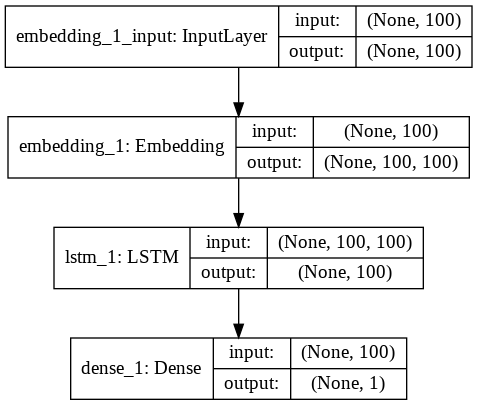

In [9]:
    plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

# **Training the model**

In [10]:
    # Training the model
    model.fit(X_train, y_train, epochs=50, batch_size=30, validation_split=0.2, 
              callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)]) 

Train on 912 samples, validate on 229 samples
Epoch 1/50
912/912 [==============================] - 3s 3ms/step - loss: 0.6428 - acc: 0.6502 - val_loss: 0.6562 - val_acc: 0.6550
Epoch 2/50
912/912 [==============================] - 3s 3ms/step - loss: 0.5644 - acc: 0.7259 - val_loss: 0.5953 - val_acc: 0.7162
Epoch 3/50
912/912 [==============================] - 3s 3ms/step - loss: 0.5204 - acc: 0.7544 - val_loss: 0.5626 - val_acc: 0.7249
Epoch 4/50
912/912 [==============================] - 3s 3ms/step - loss: 0.4787 - acc: 0.7873 - val_loss: 0.5927 - val_acc: 0.6943


# **Testing the model**

In [11]:
    # Testing the model
    pred = model.predict_classes(X_test)
    acc = model.evaluate(X_test, y_test)
    print("Test loss is {0:.2f} accuracy is {1:.2f}  ".format(acc[0],acc[1]))

286/286 [==============================] - 0s 788us/step
Test loss is 0.53 accuracy is 0.74  


In [0]:
    def message_to_array(msg):
        msg = msg.lower().split(' ')
        test_seq = np.array([word_index[word] for word in msg])
        test_seq = np.pad(test_seq, (100-len(test_seq), 0), 'constant', constant_values=(0)) 
        test_seq = test_seq.reshape(1, 100) 
        return test_seq

In [13]:
    custom_msg = 'I like it' 
    test_seq = message_to_array(custom_msg)
    pred = model.predict_classes(test_seq)
    print(pred)

[[1]]


# **Classification reports (accuracy, precision, recall, f1-score)**

In [14]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

pred = model.predict_classes(X_test)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.83      0.63      0.71       147
           1       0.69      0.86      0.76       139

    accuracy                           0.74       286
   macro avg       0.76      0.74      0.74       286
weighted avg       0.76      0.74      0.74       286



In [15]:
cnf_matrix = confusion_matrix(y_test, pred)
cnf_matrix

array([[ 92,  55],
       [ 19, 120]])

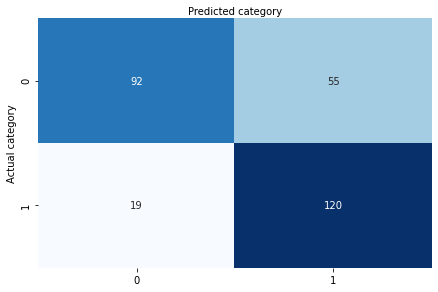

In [16]:
class_names = ["0", "1"]
fig,ax = plt.subplots()

sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="Blues", fmt="d", cbar=False, xticklabels=class_names, yticklabels=class_names)
ax.xaxis.set_label_position('top')
plt.tight_layout()
plt.ylabel('Actual category')
plt.xlabel('Predicted category');